FOR THIS CODE TO RUN THE DATASET MUST BE ADDED TO THE DIRECTORYF - SINCE THE SPECIFICATION DOES NOT CALL FOR THE DATASET IN THE DELIVERABLE IT IS NOT INCLUDED IN THE SUBMISSION AND THIS CODE WILL NOT RUN

In [1]:
!pip list

Package                   Version
------------------------- -----------
absl-py                   2.1.0
aiohappyeyeballs          2.4.4
aiohttp                   3.11.10
aiosignal                 1.2.0
anyio                     4.6.2
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asttokens                 2.0.5
astunparse                1.6.3
async-lru                 2.0.4
async-timeout             5.0.1
attrs                     24.3.0
babel                     2.16.0
backcall                  0.2.0
beautifulsoup4            4.12.3
bleach                    6.2.0
blinker                   1.9.0
Bottleneck                1.4.2
Brotli                    1.0.9
cachetools                5.5.1
certifi                   2025.1.31
cffi                      1.17.1
charset-normalizer        3.3.2
click                     8.1.7
colorama                  0.4.6
comm                      0.2.1
contourpy                 1.2.1
cryptography              41.0.3
cycler             

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image
from imblearn.keras import BalancedBatchGenerator
from imblearn.over_sampling import RandomOverSampler
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
input_folder = "brain_tumor_dataset" 
# yes_count = len(os.listdir(os.path.join(input_folder, "yes")))
# no_count = len(os.listdir(os.path.join(input_folder, "no")))

# Define the correct folder
folder_path = os.path.join(input_folder,"no")

# Fix file names
for file in os.listdir(folder_path):
    old_path = os.path.join(folder_path, file)

    # Convert to lowercase
    new_name = file.lower()
    
    # Replace spaces with underscores
    new_name = new_name.replace(" ", "_")

    # Convert to .jpg if not already
    if not new_name.endswith(".jpg"):
        new_name = os.path.splitext(new_name)[0] + ".jpg"

    new_path = os.path.join(folder_path, new_name)
    
    # Rename the file
    os.rename(old_path, new_path)

    # Convert image format if needed
    try:
        img = Image.open(new_path)
        img.convert("RGB").save(new_path)
    except Exception as e:
        print(f"Skipping {new_name}: {e}")

print("File names and formats fixed!")

File names and formats fixed!


In [30]:
# Get all image paths and labels
image_paths = []
labels = []

for label in ['yes', 'no']:  # Assuming 'yes' for tumors and 'no' for no tumors
    folder_path = os.path.join(input_folder, label)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.JPG')):  # Ensure it's an image
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(label)

# Create a DataFrame
df = pd.DataFrame({'filepath': image_paths, 'label': labels})

# Split into train (70%), validation (15%), and test (15%)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42)


In [31]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32 

In [32]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,  # Usually not flipped vertically for brain MRIs
    validation_split=0.2
)

In [33]:
print(test_df.head())

                             filepath label
118   brain_tumor_dataset\yes\Y62.jpg   yes
71   brain_tumor_dataset\yes\Y244.JPG   yes
150  brain_tumor_dataset\no\11_no.jpg    no
32   brain_tumor_dataset\yes\Y157.JPG   yes
27    brain_tumor_dataset\yes\Y15.jpg   yes


In [34]:
# Create training set
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",  # Add this line
    y_col="label", 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=['yes','no'], #to ignore the outlier folder
    subset="training",
    shuffle=True,
    class_mode='binary'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df, 
    x_col="filepath",  # Add this line
    y_col="label", 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=['yes','no'],
    subset="validation",
    shuffle=False,  # No shuffling to ensure consistency
    class_mode='binary'
)

# # Get the current working directory where the script is located
# script_dir = os.path.dirname(os.path.realpath(__file__))  # Path to the directory of the script

# # Dataset folder relative to the script's location
# dataset_folder = os.path.join(script_dir, "brain_tumor_dataset")  # relative path to your dataset

# # Ensure filepath column uses consistent path formatting
# test_df["filepath"] = test_df["filepath"].apply(lambda x: x.replace("\\", "/"))  # Replace backslashes with forward slashes

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=['yes','no'],
    class_mode="binary",
    shuffle=False
)

Found 124 validated image filenames belonging to 2 classes.
Found 6 validated image filenames belonging to 2 classes.
Found 34 validated image filenames belonging to 2 classes.


In [35]:
print("Class indices:", train_generator.class_indices)

Class indices: {'yes': 0, 'no': 1}


In [36]:
# Load VGG16 model without top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers so they are not trainable
base_model.trainable = False

# Add a custom classifier on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

In [37]:
import numpy as np
# Get the class distribution
y_classes = train_generator.classes
unique_classes = np.unique(y_classes)

# Compute balanced weights
# This automatically gives higher weight to the minority class (non-tumor/no=1)
# class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_classes)
# class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict = {0:1.0,1:5}

print("Class weights:", class_weight_dict)

Class weights: {0: 1.0, 1: 5}


In [38]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]


Epoch 1/20
4/4 [==============================] - 40s 8s/step - loss: 2.9181 - accuracy: 0.5806 - precision_5: 0.4030 - recall_5: 0.6923 - auc_5: 0.7097 - val_loss: 43.1002 - val_accuracy: 0.6667 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.5000 - lr: 0.0100
Epoch 2/20
4/4 [==============================] - 31s 8s/step - loss: 2.5141 - accuracy: 0.7097 - precision_5: 0.5238 - recall_5: 0.8462 - auc_5: 0.8023 - val_loss: 26.6451 - val_accuracy: 0.6667 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.5000 - lr: 0.0100
Epoch 3/20
4/4 [==============================] - 30s 7s/step - loss: 0.8427 - accuracy: 0.8065 - precision_5: 0.6190 - recall_5: 1.0000 - auc_5: 0.9480 - val_loss: 22.2066 - val_accuracy: 0.6667 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.5000 - lr: 0.0100
Epoch 4/20
4/4 [==============================] - 33s 9s/step - loss: 0.7111 - accuracy: 0.8468 - precision_5: 0.6923 - recall_5: 0.9231 - auc

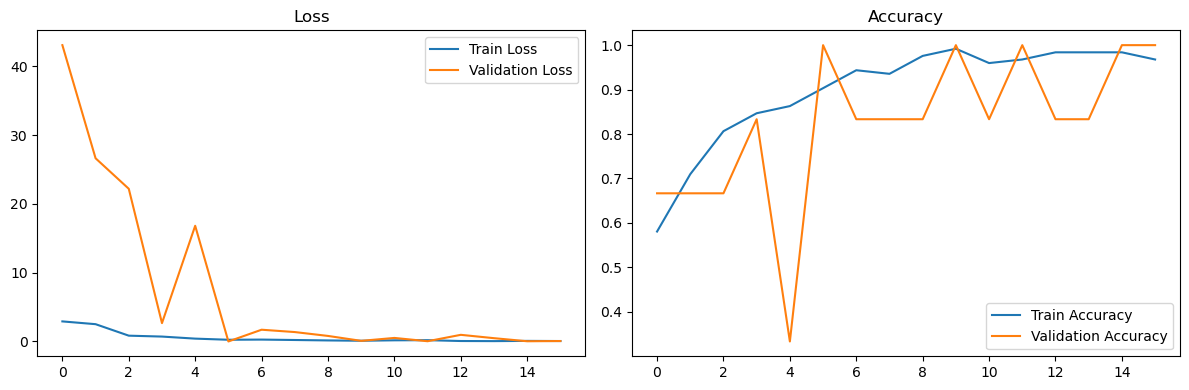

In [39]:

# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall(), AUC()]
)

# Train with class weights
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Fine-tuning
# Unfreeze the model gradually
for layer in base_model.layers[-30:]:
    layer.trainable = True
    
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall(), AUC()]
)

history_ft = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    initial_epoch=history.epoch[-1]
)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Get predictions on validation data
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
threshold = 0.5 
y_pred = (y_pred_prob > threshold).astype(int).flatten()

2/2 [==============================] - 9s 622ms/step


In [41]:
import pandas as pd

# Create a DataFrame with actual labels and predicted probabilities
df = pd.DataFrame({
    "True_Label": y_true,
    "Predicted_Probability": y_pred_prob.flatten()
})

# Save to CSV
df.to_csv("model_predictions.csv", index=False)

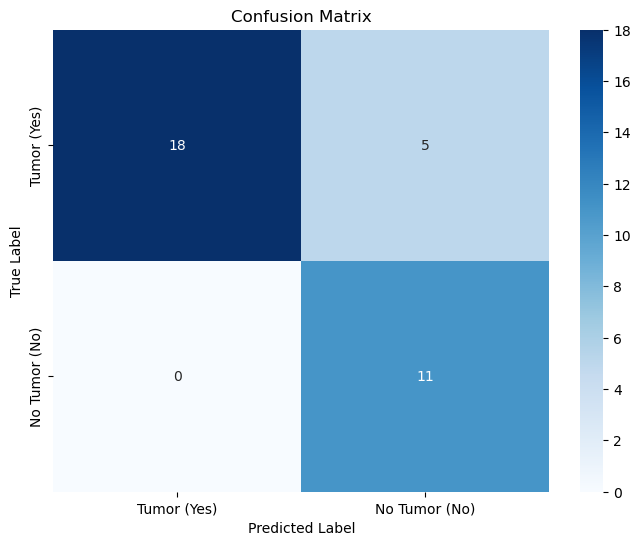

In [42]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Tumor (Yes)", "No Tumor (No)"], 
            yticklabels=["Tumor (Yes)", "No Tumor (No)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [43]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=["Tumor", "No Tumor"]))

              precision    recall  f1-score   support

       Tumor       1.00      0.78      0.88        23
    No Tumor       0.69      1.00      0.81        11

    accuracy                           0.85        34
   macro avg       0.84      0.89      0.85        34
weighted avg       0.90      0.85      0.86        34



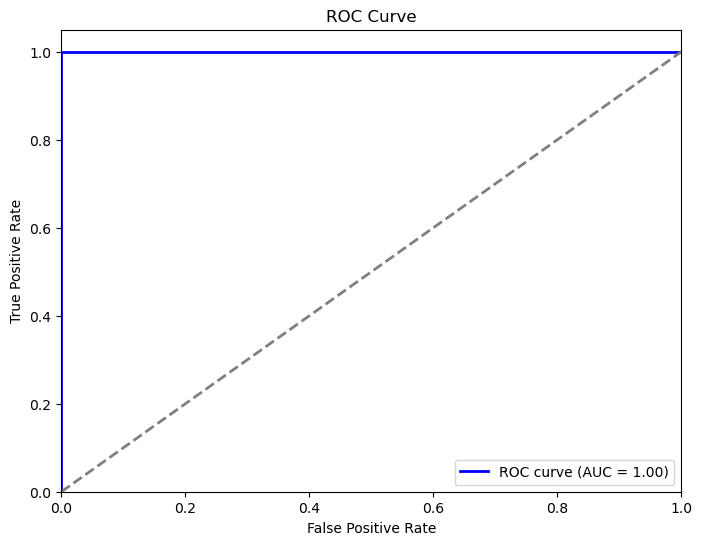

In [44]:
# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Number of misclassified images: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-99.438995..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..134.4501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..144.65137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..149.54333].


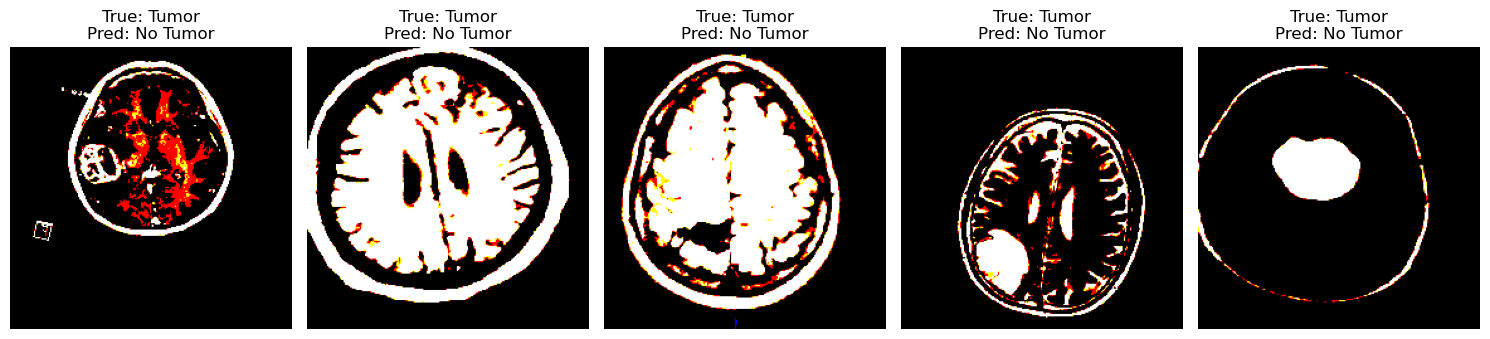

In [45]:
# Find misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Function to get misclassified images
def get_image_from_generator(generator, index):
    batch_idx = index // generator.batch_size
    in_batch_idx = index % generator.batch_size
    
    # Reset generator and get the right batch
    generator.reset()
    for _ in range(batch_idx + 1):
        batch_x, batch_y = next(generator)
        
    return batch_x[in_batch_idx], batch_y[in_batch_idx]

# Display a few misclassified examples
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:5]):
    img, true_label = get_image_from_generator(test_generator, idx)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {'Tumor' if true_label == 0 else 'No Tumor'}\nPred: {'Tumor' if y_pred[idx] == 0 else 'No Tumor'}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [47]:
        ####################################
        ####################################
        ### EfficientNetB0 for comparison###
        ####################################
        #################################### 

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [79]:
BATCH_SIZE = 16  #lowered from 32 (crashes on my otherwise)

In [80]:
# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=x)

# Class weights for handling imbalanced data
class_weight_dict = {0: float(1.0), 1: float(5.0)}   # Adjust based on dataset balance
print("Class weights:", class_weight_dict)


# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    #ModelCheckpoint('best_efficientnetb0.h5', save_best_only=True, monitor='val_loss')
]

Class weights: {0: 1.0, 1: 5.0}


Epoch 1/20
4/4 [==============================] - 35s 4s/step - loss: 1.6933 - accuracy: 0.6290 - precision_10: 0.4386 - recall_10: 0.6410 - auc_10: 0.6517 - val_loss: 0.6285 - val_accuracy: 0.6667 - val_precision_10: 0.5000 - val_recall_10: 1.0000 - val_auc_10: 1.0000 - lr: 1.0000e-04
Epoch 2/20
4/4 [==============================] - 5s 950ms/step - loss: 1.0825 - accuracy: 0.7258 - precision_10: 0.5424 - recall_10: 0.8205 - auc_10: 0.8357 - val_loss: 0.5510 - val_accuracy: 0.8333 - val_precision_10: 0.6667 - val_recall_10: 1.0000 - val_auc_10: 1.0000 - lr: 1.0000e-04
Epoch 3/20
4/4 [==============================] - 4s 939ms/step - loss: 0.9964 - accuracy: 0.7419 - precision_10: 0.5593 - recall_10: 0.8462 - auc_10: 0.8557 - val_loss: 0.5207 - val_accuracy: 1.0000 - val_precision_10: 1.0000 - val_recall_10: 1.0000 - val_auc_10: 1.0000 - lr: 1.0000e-04
Epoch 4/20
4/4 [==============================] - 4s 1s/step - loss: 0.6323 - accuracy: 0.8065 - precision_10: 0.6230 - recall_10: 0.97

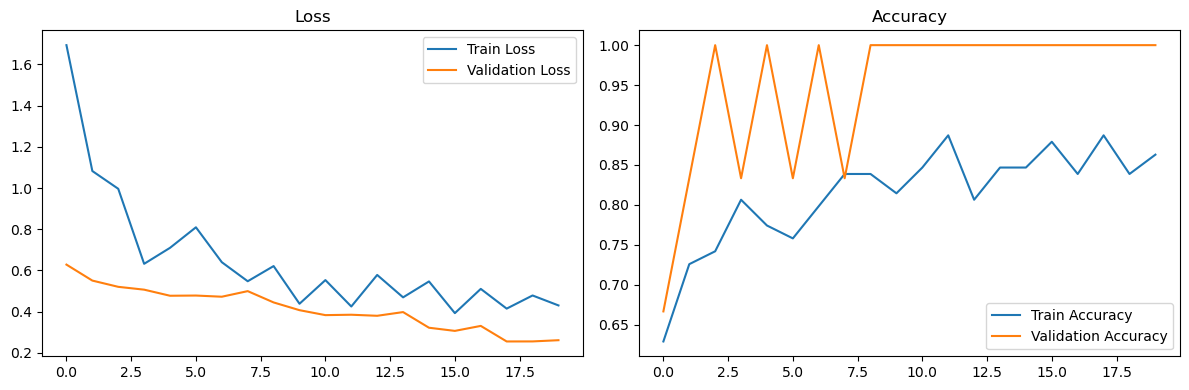

Epoch 1/10
4/4 [==============================] - 127s 22s/step - loss: 0.6581 - accuracy: 0.7661 - precision: 0.5781 - recall: 0.9487 - auc: 0.9284 - val_loss: 0.2625 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - lr: 1.0000e-04
Epoch 2/10
4/4 [==============================] - 97s 16s/step - loss: 0.5711 - accuracy: 0.8468 - precision: 0.6852 - recall: 0.9487 - auc: 0.9520 - val_loss: 0.2050 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - lr: 1.0000e-04
Epoch 3/10
4/4 [==============================] - 162s 39s/step - loss: 0.8326 - accuracy: 0.8065 - precision: 0.6364 - recall: 0.8974 - auc: 0.9012 - val_loss: 0.1758 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - lr: 1.0000e-04
Epoch 4/10
4/4 [==============================] - 127s 38s/step - loss: 0.4641 - accuracy: 0.8387 - precision: 0.6727 - recall: 0.9487 - auc: 0.9725 - val_loss: 0.2304 - val_accuracy: 1.00

In [81]:

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall(), AUC()]
)

# model.run_eagerly = True
# Train with class weights
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Fine-tuning: Unfreeze last few layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile for fine-tuning with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

model.run_eagerly = True
# Train fine-tuned model
history_ft = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weight_dict
    # initial_epoch=history.epoch[-1]
)

In [82]:
# Predictions and Evaluation
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred_prob = np.array(y_pred_prob).flatten() 
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

2/2 [==============================] - 3s 453ms/step


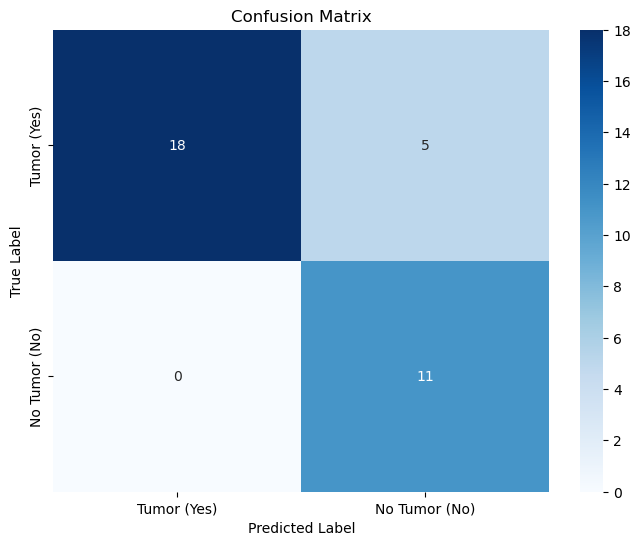

In [83]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Tumor (Yes)", "No Tumor (No)"], 
            yticklabels=["Tumor (Yes)", "No Tumor (No)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [84]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=["Tumor", "No Tumor"]))


              precision    recall  f1-score   support

       Tumor       1.00      0.78      0.88        23
    No Tumor       0.69      1.00      0.81        11

    accuracy                           0.85        34
   macro avg       0.84      0.89      0.85        34
weighted avg       0.90      0.85      0.86        34



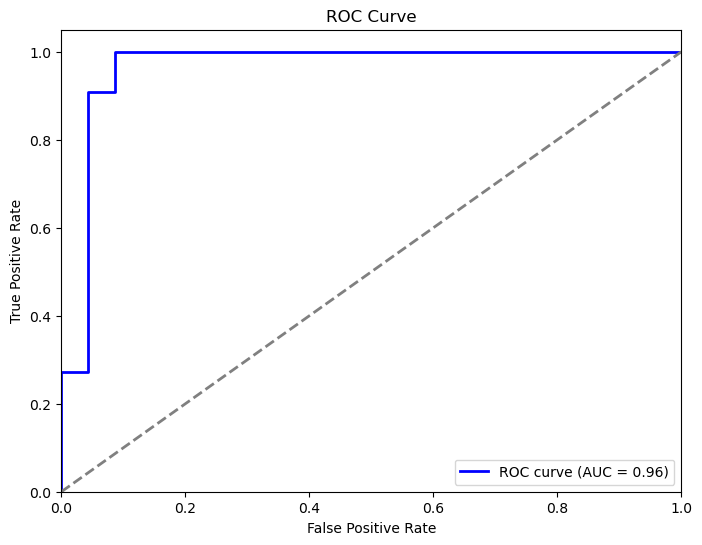

In [85]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [86]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_8 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 224, 224, 3)  7          ['rescaling_8[0][0]']            
 )                                                                                                
                                                                                            

Number of misclassified images: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..122.31817].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-97.4137..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..138.4961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-112.55939..151.061].


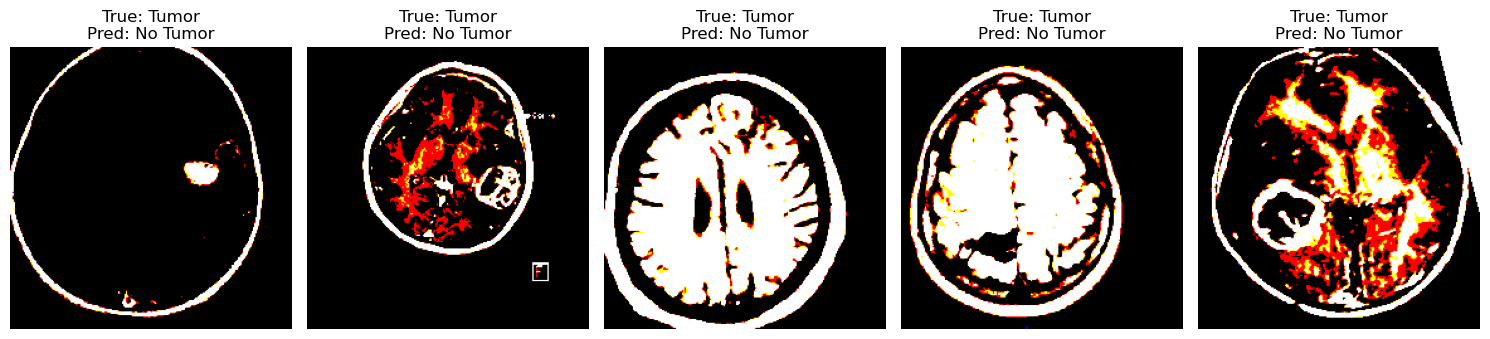

In [87]:
                 # Find misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Function to get misclassified images
def get_image_from_generator(generator, index):
    batch_idx = index // generator.batch_size
    in_batch_idx = index % generator.batch_size
    
    # Reset generator and get the right batch
    generator.reset()
    for _ in range(batch_idx + 1):
        batch_x, batch_y = next(generator)
        
    return batch_x[in_batch_idx], batch_y[in_batch_idx]

# Display a few misclassified examples
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:5]):
    img, true_label = get_image_from_generator(test_generator, idx)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {'Tumor' if true_label == 0 else 'No Tumor'}\nPred: {'Tumor' if y_pred[idx] == 0 else 'No Tumor'}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()                                                                                               